**Ecuación de Ornstein-Uhlenbeck**

El proceso de Ornstein-Uhlenbeck es un proceso estocástico con reversión a la media. A diferencia del Movimiento Browniano Geométrico (usado en Black-Scholes), donde el precio tiende a alejarse indefinidamente, el proceso OU tiende a volver a un nivel de equilibrio a largo plazo $\mu$ con una velocidad $\theta$. Este modelo es ampliamente utilizado para modelar tasas de interés (modelo Vasicek), volatilidad estocástica o sistemas físicos con fricción.

La ecuación diferencial estocástica está dada por:$$dS_t = \theta (\mu - S_t) dt + \sigma dW_t$$

Donde:

- $S_t$: Valor del proceso en el tiempo $t$.
- $\mu$ (Mu): Media a largo plazo o nivel de equilibrio.
- $\theta$ (Theta): Velocidad de reversión a la media. Cuanto mayor sea $\theta$, más rápido regresa el proceso a $\mu$ tras una perturbación.
- $\sigma$ (Sigma): Volatilidad (constante de difusión).
- $W_t$: Proceso de Wiener (Movimiento Browniano estándar).

Para resolver esto con una Physics-Informed Neural Network (PINN) utilizando la expansión de Karhunen-Loève para el ruido, aproximamos el ruido blanco $\frac{dW}{dt}$ como una función suave (aunque rugosa) dependiente de las variables aleatorias $\zeta$.Reordenamos la SDE para obtener el residuo que la red neuronal debe minimizar:$$\mathcal{R}(S) = \frac{dS}{dt} - \underbrace{\theta (\mu - S)}_{\text{Drift}} - \underbrace{\sigma \frac{dW}{dt}}_{\text{Difusión}} = 0$$

In [71]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [72]:
def dWdt_kl_torch(t, zetas, T):
    N, n_terms = zetas.shape
    k = torch.arange(1, n_terms + 1, device=t.device).view(1, -1)
    t_hat = t / T
    arg = (k - 0.5) * math.pi * t_hat
    cos_term = torch.cos(arg)
    sum_term = (zetas * cos_term).sum(dim=1, keepdim=True)
    factor = math.sqrt(2.0 / float(T))
    return factor * sum_term

def W_kl_torch(t, zetas, T):
    N, n_terms = zetas.shape
    k = torch.arange(1, n_terms + 1, device=t.device).view(1, -1)
    t_hat = t / T
    arg = (k - 0.5) * math.pi * t_hat
    sin_term = torch.sin(arg)
    coeff = math.sqrt(2.0 * float(T)) / ((k - 0.5) * math.pi)
    W = (zetas * coeff * sin_term).sum(dim=1, keepdim=True)
    return W

In [74]:
class OUSPINN(nn.Module):
    """
    PINN que aproxima S(t, ζ) directamente.
    No usamos logaritmo porque OU puede S puede ser negativo.
    """
    def __init__(self, T, n_terms, hidden_dim=64, n_hidden=3):
        super().__init__()
        self.T  = T
        self.n_terms = n_terms
        

        in_dim = 1 + n_terms 
        out_dim = 1         

        layers = [nn.Linear(in_dim, hidden_dim), nn.Tanh()]
        for _ in range(n_hidden - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers += [nn.Linear(hidden_dim, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, t, zetas):
        t_norm = t / self.T
        x = torch.cat([t_norm, zetas], dim=1)
        s_pred = self.net(x)
        return s_pred

In [75]:
def residual_pde_ou(model, t, zetas, theta, mu, sigma, T):
    t_req = t.clone().detach().requires_grad_(True)
    z_req = zetas.clone().detach()

    s_pred = model(t_req, z_req)

    ds_dt = torch.autograd.grad(
        s_pred,
        t_req,
        grad_outputs=torch.ones_like(s_pred),
        create_graph=True
    )[0]

    dWdt = dWdt_kl_torch(t_req, z_req, T)
    drift = theta * (mu - s_pred)
    diffusion = sigma * dWdt
    
    
    rhs = drift + diffusion
    
    res = ds_dt - rhs
    return res, s_pred

In [76]:
class OrnsteinUhlenbeckKL:
    """
    Genera trayectorias de la SDE OU:
        dS = theta (mu - S) dt + sigma dW_t
    """

    def __init__(self, S0, theta, mu, sigma, T, n_terms=20):
        self.S0    = S0
        self.theta = theta
        self.mu    = mu
        self.sigma = sigma
        self.T     = T
        self.n_terms = n_terms
        self.zetas = np.random.normal(0, 1, size=self.n_terms).astype(np.float32)

    def W_kl(self, t):
        t = np.array(t, ndmin=1)
        t_hat = t / self.T
        k = np.arange(1, self.n_terms + 1)
        numer = np.sin((k - 0.5) * np.pi * t_hat[:, None])
        denom = (k - 0.5) * np.pi
        W = np.sqrt(2 * self.T) * np.sum(self.zetas[None, :] * numer / denom, axis=1)
        return W  

    def simulate_path(self, N=200):
        t = np.linspace(0, self.T, N)
        dt = t[1] - t[0]

        W = self.W_kl(t)
        dW = np.diff(W)

        S = np.zeros(N, dtype=np.float32)
        S[0] = self.S0

        for i in range(N - 1):
            drift = self.theta * (self.mu - S[i])
            S[i+1] = S[i] + drift * dt + self.sigma * dW[i]

        return t, S, W

def generate_ou_data_from_KL(S0, theta, mu, sigma, T, n_terms,
                             N_time=200, N_paths=20):
    all_t = []
    all_z = []
    all_S = []

    for _ in range(N_paths):
        sim = OrnsteinUhlenbeckKL(S0, theta, mu, sigma, T, n_terms=n_terms)
        t, S, W = sim.simulate_path(N=N_time)
        zetas = sim.zetas  
        z_path = np.tile(zetas, (N_time, 1))

        all_t.append(t.reshape(-1, 1))
        all_z.append(z_path)
        all_S.append(S.reshape(-1, 1))

    t_data = np.vstack(all_t)
    z_data = np.vstack(all_z)
    S_data = np.vstack(all_S)
    return t_data, z_data, S_data


In [78]:
def pinn_loss_ou(model, theta, mu, sigma, S0, T, n_terms,
                   N_colloc=1024, N_ic=128, device="cpu"):


    t_colloc = torch.rand(N_colloc, 1, device=device) * T
    z_colloc = torch.randn(N_colloc, n_terms, device=device)

    res, _ = residual_pde_ou(model, t_colloc, z_colloc, theta, mu, sigma, T)
    loss_pde = torch.mean(res**2)

    t_ic = torch.zeros(N_ic, 1, device=device)
    z_ic = torch.randn(N_ic, n_terms, device=device)
    
    s0_pred = model(t_ic, z_ic)
    loss_ic = torch.mean((s0_pred - S0)**2)

    return loss_pde + loss_ic, loss_pde.detach(), loss_ic.detach()

def pinn_loss_ou_with_data(model, theta, mu, sigma, S0, T, n_terms,
                           t_data=None, z_data=None, S_data=None,
                           lambda_data=1.0,
                           N_colloc=1024, N_ic=128, device="cpu"):

    t_colloc = torch.rand(N_colloc, 1, device=device) * T
    z_colloc = torch.randn(N_colloc, n_terms, device=device)

    res, _ = residual_pde_ou(model, t_colloc, z_colloc, theta, mu, sigma, T)
    loss_pde = torch.mean(res**2)

    t_ic = torch.zeros(N_ic, 1, device=device)
    z_ic = torch.randn(N_ic, n_terms, device=device)

    S0_pred = model(t_ic, z_ic)
    loss_ic = torch.mean((S0_pred - S0)**2)

    loss_data = torch.tensor(0.0, device=device)
    if t_data is not None and z_data is not None and S_data is not None:
        S_pred_data = model(t_data, z_data)
        loss_data = torch.mean((S_pred_data - S_data)**2)

    loss_total = loss_pde + loss_ic + lambda_data * loss_data
    return loss_total, loss_pde.detach(), loss_ic.detach(), loss_data.detach()


S0_val    = 0.5
theta_val = 2.5
mu_val    = 0.05
sigma_val = 0.05
T_val     = 1.0
n_terms   = 50
N_time        = 200
N_paths_total = 40  

t_all_np, z_all_np, S_all_np = generate_ou_data_from_KL(
    S0_val, theta_val, mu_val, sigma_val,
    T_val, n_terms,
    N_time=N_time,
    N_paths=N_paths_total
)

N_total = t_all_np.shape[0]
idx     = np.random.permutation(N_total)
split   = int(0.8 * N_total)

idx_train = idx[:split]
idx_test  = idx[split:]

t_train_np = t_all_np[idx_train]
z_train_np = z_all_np[idx_train]
S_train_np = S_all_np[idx_train]

t_test_np  = t_all_np[idx_test]
z_test_np  = z_all_np[idx_test]
S_test_np  = S_all_np[idx_test]


t_train = torch.tensor(t_train_np, dtype=torch.float32, device=device)
z_train = torch.tensor(z_train_np, dtype=torch.float32, device=device)
S_train = torch.tensor(S_train_np, dtype=torch.float32, device=device)

t_test  = torch.tensor(t_test_np,  dtype=torch.float32, device=device)
z_test  = torch.tensor(z_test_np,  dtype=torch.float32, device=device)
S_test  = torch.tensor(S_test_np,  dtype=torch.float32, device=device)



S0_t    = torch.tensor(S0_val,    dtype=torch.float32, device=device)
theta_t = torch.tensor(theta_val, dtype=torch.float32, device=device)
mu_t    = torch.tensor(mu_val,    dtype=torch.float32, device=device)
sigma_t = torch.tensor(sigma_val, dtype=torch.float32, device=device)
T_t     = torch.tensor(T_val,     dtype=torch.float32, device=device)



In [79]:
model_phys = OUSPINN(T_t, n_terms, hidden_dim=128, n_hidden=3).to(device)
optimizer_phys = optim.Adam(model_phys.parameters(), lr=1e-3)

print("Entrenando OUSPINN (solo física)...")
n_epochs = 5000

for epoch in range(1, n_epochs + 1):
    optimizer_phys.zero_grad()
    loss, loss_pde, loss_ic = pinn_loss_ou(
        model_phys, theta_t, mu_t, sigma_t, S0_t, T_t, n_terms,
        N_colloc=1024, N_ic=128, device=device
    )
    loss.backward()
    optimizer_phys.step()

    if epoch % 500 == 0:
        print(f"[PHYS] Epoch {epoch:5d} | Loss: {loss.item():.4e} | PDE: {loss_pde.item():.4e} | IC: {loss_ic.item():.4e}")

model_data = OUSPINN(T_t, n_terms, hidden_dim=128, n_hidden=3).to(device)
optimizer_data = optim.Adam(model_data.parameters(), lr=1e-3)

lambda_data = 1.0 

print("Entrenando OUSPINN (física + datos)...")
n_epochs = 5000

for epoch in range(1, n_epochs + 1):
    optimizer_data.zero_grad()
    loss, loss_pde, loss_ic, loss_data = pinn_loss_ou_with_data(
        model_data,
        theta_t, mu_t, sigma_t, S0_t, T_t, n_terms,
        t_data=t_train,
        z_data=z_train,
        S_data=S_train,
        lambda_data=lambda_data,
        N_colloc=1024,
        N_ic=128,
        device=device
    )
    loss.backward()
    optimizer_data.step()

    if epoch % 500 == 0:
        print(f"[DATA] Epoch {epoch:5d} | total={loss.item():.4e} | "
              f"PDE={loss_pde.item():.4e} | IC={loss_ic.item():.4e} | DATA={loss_data.item():.4e}")


Entrenando OUSPINN (solo física)...
[PHYS] Epoch   500 | Loss: 1.2748e-01 | PDE: 1.2559e-01 | IC: 1.8855e-03
[PHYS] Epoch  1000 | Loss: 1.2786e-01 | PDE: 1.2668e-01 | IC: 1.1768e-03
[PHYS] Epoch  1500 | Loss: 1.2432e-01 | PDE: 1.2312e-01 | IC: 1.1958e-03
[PHYS] Epoch  2000 | Loss: 1.2129e-01 | PDE: 1.2078e-01 | IC: 5.0534e-04
[PHYS] Epoch  2500 | Loss: 1.2564e-01 | PDE: 1.2514e-01 | IC: 5.0839e-04
[PHYS] Epoch  3000 | Loss: 1.0975e-01 | PDE: 1.0930e-01 | IC: 4.4815e-04
[PHYS] Epoch  3500 | Loss: 1.1138e-01 | PDE: 1.1070e-01 | IC: 6.7784e-04
[PHYS] Epoch  4000 | Loss: 1.0995e-01 | PDE: 1.0960e-01 | IC: 3.5199e-04
[PHYS] Epoch  4500 | Loss: 9.8453e-02 | PDE: 9.8046e-02 | IC: 4.0691e-04
[PHYS] Epoch  5000 | Loss: 1.0607e-01 | PDE: 1.0583e-01 | IC: 2.4062e-04
Entrenando OUSPINN (física + datos)...
[DATA] Epoch   500 | total=1.2410e-01 | PDE=1.2174e-01 | IC=1.7068e-03 | DATA=6.5519e-04
[DATA] Epoch  1000 | total=1.2216e-01 | PDE=1.2116e-01 | IC=7.3595e-04 | DATA=2.7004e-04
[DATA] Epoch  150

In [81]:
def evaluate_ou_model(model, t_test, z_test, S_test):
    model.eval()
    with torch.no_grad():
        S_pred = model(t_test, z_test)
        mse = torch.mean((S_pred - S_test)**2).item()
        mae = torch.mean(torch.abs(S_pred - S_test)).item()
        rel = torch.mean(torch.abs(S_pred - S_test) / (torch.abs(S_test) + 1e-8)).item()
    return mse, mae, rel


In [82]:
mse_phys, mae_phys, rel_phys = evaluate_ou_model(model_phys, t_test, z_test, S_test)
mse_data, mae_data, rel_data = evaluate_ou_model(model_data, t_test, z_test, S_test)

print("=== RESULTADOS EN TEST (OU) ===")
print(f"Física pura:  MSE={mse_phys:.3e} | MAE={mae_phys:.3e} | RelErr={rel_phys:.3e}")
print(f"Física+datos: MSE={mse_data:.3e} | MAE={mae_data:.3e} | RelErr={rel_data:.3e}")


=== RESULTADOS EN TEST (OU) ===
Física pura:  MSE=1.664e-04 | MAE=9.905e-03 | RelErr=5.500e-02
Física+datos: MSE=1.438e-04 | MAE=9.643e-03 | RelErr=6.245e-02


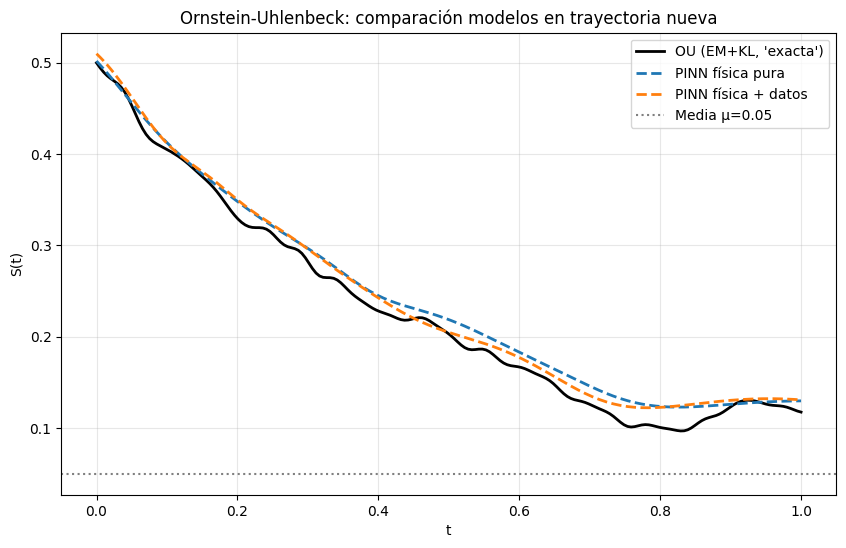

In [83]:
sim_new = OrnsteinUhlenbeckKL(S0_val, theta_val, mu_val, sigma_val, T_val, n_terms=n_terms)
t_new_np, S_new_np, W_new_np = sim_new.simulate_path(N=200)
zetas_new = sim_new.zetas

t_new = torch.tensor(t_new_np, dtype=torch.float32, device=device).view(-1, 1)
z_new = torch.tensor(np.tile(zetas_new, (t_new_np.shape[0], 1)),
                     dtype=torch.float32, device=device)

with torch.no_grad():
    S_phys_new = model_phys(t_new, z_new).cpu().numpy().ravel()
    S_data_new = model_data(t_new, z_new).cpu().numpy().ravel()

plt.figure(figsize=(10, 6))
plt.plot(t_new_np, S_new_np, label="OU (EM+KL, 'exacta')", linewidth=2, color='black')
plt.plot(t_new_np, S_phys_new, "--", label="PINN física pura", linewidth=2)
plt.plot(t_new_np, S_data_new, "--", label="PINN física + datos", linewidth=2)
plt.axhline(y=mu_val, color='gray', linestyle=':', label=f'Media μ={mu_val}')
plt.xlabel("t")
plt.ylabel("S(t)")
plt.title("Ornstein-Uhlenbeck: comparación modelos en trayectoria nueva")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
